In [17]:
# Cài đặt Java (Spark chạy trên nền Java)
!apt-get install openjdk-11-jdk-headless -qq

# Cài đặt PySpark
!pip install pyspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
!pip install pyspark==3.4.1

##Khai báo thư viện

In [18]:
from pyspark.sql import SparkSession, functions as F
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, PolynomialExpansion, StandardScaler
from pyspark.sql.functions import col, avg, exp, abs, mean, stddev
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.window import Window
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from functools import reduce

##Đọc dữ liệu

In [19]:
# Khởi tạo SparkSession
spark = SparkSession.builder\
.appName('DuBaoTyGia')\
.getOrCreate()

In [20]:
# Đọc dữ liệu
df = spark.read.csv('df_processed_with_features.csv', header= True, inferSchema= True )
df.show(5)

+----------+------------+------------+------------+-------------+-------------+----+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+----------------------+----------------------+----------------------+----------------------+------------+--------------------+--------------------+--------------------+--------------------+
|      Ngày|Lần cuối_vnd|Lần cuối_cny|Lần cuối_dxy|Lần cuối_gold|Lần cuối_bond| DFF|    CPI|    Lần cuối_vnd_ret|    Lần cuối_cny_ret|    Lần cuối_dxy_ret|   Lần cuối_gold_ret|   Lần cuối_bond_ret|             DFF_ret|             CPI_ret|Lần cuối_vnd_ret_lag1|Lần cuối_vnd_ret_lag3|Lần cuối_cny_ret_lag1|Lần cuối_cny_ret_lag3|Lần cuối_dxy_ret_lag1|Lần cuối_dxy_ret_lag3|Lần cuối_gold_ret_lag1|Lần cuối_gold_ret_lag3|Lần cuối_bond_ret_lag1

##Phân tích mô tả

In [21]:
# Thông tin chung
df.printSchema()

root
 |-- Ngày: date (nullable = true)
 |-- Lần cuối_vnd: double (nullable = true)
 |-- Lần cuối_cny: double (nullable = true)
 |-- Lần cuối_dxy: double (nullable = true)
 |-- Lần cuối_gold: double (nullable = true)
 |-- Lần cuối_bond: double (nullable = true)
 |-- DFF: double (nullable = true)
 |-- CPI: double (nullable = true)
 |-- Lần cuối_vnd_ret: double (nullable = true)
 |-- Lần cuối_cny_ret: double (nullable = true)
 |-- Lần cuối_dxy_ret: double (nullable = true)
 |-- Lần cuối_gold_ret: double (nullable = true)
 |-- Lần cuối_bond_ret: double (nullable = true)
 |-- DFF_ret: double (nullable = true)
 |-- CPI_ret: double (nullable = true)
 |-- Lần cuối_vnd_ret_lag1: double (nullable = true)
 |-- Lần cuối_vnd_ret_lag3: double (nullable = true)
 |-- Lần cuối_cny_ret_lag1: double (nullable = true)
 |-- Lần cuối_cny_ret_lag3: double (nullable = true)
 |-- Lần cuối_dxy_ret_lag1: double (nullable = true)
 |-- Lần cuối_dxy_ret_lag3: double (nullable = true)
 |-- Lần cuối_gold_ret_lag1: do

In [22]:
cols = ['target',
        'Lần cuối_vnd_ret','Lần cuối_vnd_ret_lag1','Lần cuối_vnd_ret_lag3',
        'Lần cuối_cny_ret','Lần cuối_cny_ret_lag1',
        'Lần cuối_dxy_ret','Lần cuối_dxy_ret_lag1',
        'Lần cuối_gold_ret','Lần cuối_gold_ret_lag1',
        'Lần cuối_bond_ret','Lần cuối_bond_ret_lag1',
        'DFF_ret','DFF_ret_lag1',
        'CPI_ret','CPI_ret_lag1']

###Bảng thống kê

In [23]:
table = dict()
table[''] = ['Min','Max','Mean','Var','Std','Q1','Q2','Q3']
for i in cols:
  s = df.select(
      F.min(i).alias('Min'),
      F.max(i).alias('Max'),
      F.mean(i).alias('Mean'),
      F.variance(i).alias('Var'),
      F.stddev(i).alias('Std'),
      F.expr(f'percentile_approx(`{i}`, array(0.25,0.5,0.75))').alias('Q')
  ).first()
  table[i] = [s['Min'],s['Max'],s['Mean'],s['Var'],s['Std'],s['Q'][0],s['Q'][1],s['Q'][2]]
table = pd.DataFrame(table).set_index('')
table = table.round(4)
table

,target,Lần cuối_vnd_ret,Lần cuối_vnd_ret_lag1,Lần cuối_vnd_ret_lag3,Lần cuối_cny_ret,Lần cuối_cny_ret_lag1,Lần cuối_dxy_ret,Lần cuối_dxy_ret_lag1,Lần cuối_gold_ret,Lần cuối_gold_ret_lag1,Lần cuối_bond_ret,Lần cuối_bond_ret_lag1,DFF_ret,DFF_ret_lag1,CPI_ret,CPI_ret_lag1
,,,,,,,,,,,,,,,,
Min,-0.0151,-0.0456,-0.0456,-0.0456,-0.0180,-0.0180,-0.0302,-0.0302,-0.0934,-0.0934,-0.9871,-0.3241,-0.7727,-0.7727,-0.0176,-0.0176
Max,0.0241,0.0479,0.0626,0.0626,0.0161,0.0161,0.0256,0.0256,0.0897,0.0897,99.0000,99.0000,3.1250,3.1250,0.0156,0.0153
Mean,0.0001,0.0001,0.0001,0.0001,-0.0000,-0.0000,0.0001,0.0001,0.0002,0.0002,0.0249,0.0250,0.0056,0.0063,-0.0000,-0.0000
Var,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0001,2.5072,2.5069,0.0135,0.0133,0.0000,0.0000
Std,0.0011,0.0021,0.0023,0.0024,0.0021,0.0021,0.0047,0.0048,0.0108,0.0107,1.5834,1.5833,0.1163,0.1155,0.0011,0.0011
Q1,-0.0002,-0.0004,-0.0004,-0.0004,-0.0007,-0.0007,-0.0025,-0.0025,-0.0047,-0.0044,-0.0031,-0.0030,0.0000,0.0000,0.0000,0.0000
Q2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0003,0.0002,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Q3,0.0002,0.0004,0.0004,0.0004,0.0007,0.0007,0.0027,0.0027,0.0057,0.0054,0.0023,0.0021,0.0000,0.0000,0.0000,0.0000


###Ma trận tương quan

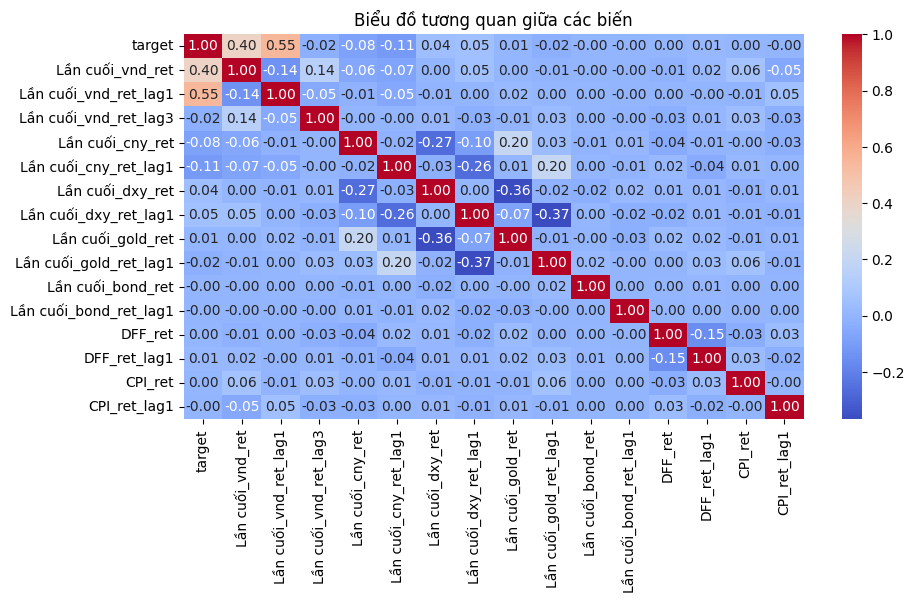

In [24]:
# Tạo vector cho các cột này (để tính tương quan)
assembler_corr = VectorAssembler(inputCols= cols, outputCol="corr_features")
df_corr = assembler_corr.transform(df).select("corr_features")
# Tính ma trận tương quan bằng Spark (Pearson)
matrix = Correlation.corr(df_corr, "corr_features").head()
corr_matrix = matrix[0].toArray()
# Vẽ biểu đồ Heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(corr_matrix,
            xticklabels=cols,
            yticklabels=cols,
            annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Biểu đồ tương quan giữa các biến")
plt.show()

##Phân tích dự báo


In [25]:
feature_cols = [
    'Lần cuối_vnd_ret_lag1',
    'Lần cuối_vnd_ret_lag3',
    'Lần cuối_cny_ret_lag1',
    'Lần cuối_dxy_ret_lag1',
    'Lần cuối_gold_ret_lag1',
    'Lần cuối_bond_ret_lag1',
    'DFF_ret_lag1'
]

In [26]:
#Biến mục tiêu
window_rolling = Window.orderBy("Ngày").rowsBetween(-2, 0)

df = df.withColumn(
    "rolling_mean_3",
    F.avg("Lần cuối_vnd_ret").over(window_rolling)
)

df = df.withColumn(
    "target",
    F.lead("rolling_mean_3", 1).over(Window.orderBy("Ngày"))
)

df = df.dropna(subset=["target"])


In [27]:
#Tạo vector đặc trưng
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

df_model = assembler.transform(df).select(
    "Ngày", "features", "target"
)

###Chia tập dữ liệu

In [28]:
train = df.filter(df.Ngày < "2021-01-01")
test  = df.filter(df.Ngày >= "2021-01-01")
print(f"Số lượng tập Train: {train.count()}")
print(f"Số lượng tập Test: {test.count()}")

Số lượng tập Train: 3046
Số lượng tập Test: 863


###Xây dựng mô hình

In [29]:
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

In [30]:
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="target",
    numTrees=500,           # số cây
    maxDepth=6,             # giảm overfitting
    minInstancesPerNode=30, # mỗi lá đủ lớn
    subsamplingRate=0.8,
    seed=42
)

In [31]:
pipeline = Pipeline(stages=[assembler, rf])

In [32]:
#Huấn luyện mô hình
rf_model = pipeline.fit(train)


In [33]:
#Dự báo mô hình
predictions = rf_model.transform(test)

###Đánh giá mô hình


In [47]:
evaluator_mae = RegressionEvaluator(
    labelCol="target",
    predictionCol="prediction",
    metricName="mae"
)

evaluator_mse = RegressionEvaluator(
    labelCol="target",
    predictionCol="prediction",
    metricName="mse"
)

evaluator_rmse = RegressionEvaluator(
    labelCol="target",
    predictionCol="prediction",
    metricName="rmse"
)

evaluator_r2 = RegressionEvaluator(
    labelCol="target",
    predictionCol="prediction",
    metricName="r2"
)

predictions_filtered = predictions.filter(F.col("target").isNotNull())

mae = evaluator_mae.evaluate(predictions_filtered)
mse = evaluator_mse.evaluate(predictions_filtered)
rmse = evaluator_rmse.evaluate(predictions_filtered)
r2 = evaluator_r2.evaluate(predictions_filtered)

print(f"MAE: {mae: ,.6f}")
print(f"MSE: {mse: ,.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"R²: {r2:.4f}")

MAE:  0.000525
MSE:  0.000001
RMSE: 0.000966
R²: 0.2176


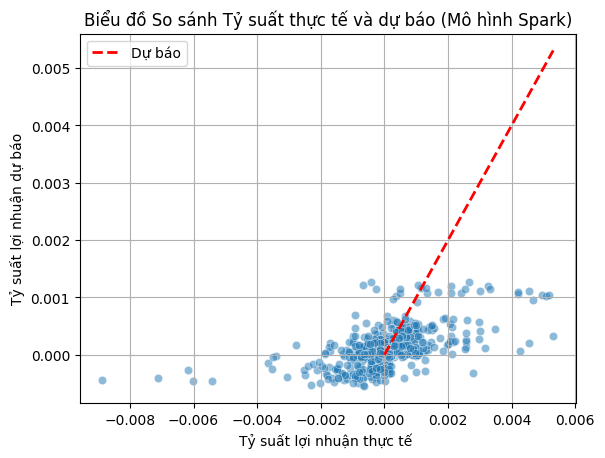

In [48]:
# Vẽ biểu đồ giá trị dự báo và giá trị thực tế
pdf = predictions.select("target", "prediction").sample(False,1.0, seed=42).toPandas()
sns.scatterplot(x='target', y='prediction', data=pdf, alpha=0.5)
# Vẽ đường chéo đỏ (kỳ vọng dự đoán trùng khít thực tế)
m_max = pdf.max().max()
plt.plot([0, m_max], [0, m_max], color='red', linestyle='--', linewidth=2, label='Dự báo')
plt.xlabel("Tỷ suất lợi nhuận thực tế ")
plt.ylabel("Tỷ suất lợi nhuận dự báo")
plt.title("Biểu đồ So sánh Tỷ suất thực tế và dự báo (Mô hình Spark)")
plt.legend()
plt.grid(True)
plt.show()

In [49]:
#Dự báo trên tập test
display(pdf.head())

,target,prediction
0,-0.000115,0.000014
1,0.000289,0.000006
2,0.000116,0.000042
3,-0.000202,0.000133
4,-0.000578,0.000005


In [50]:
# Dự báo trên tập Train
train_predictions = rf_model.transform(train)

# Chuyển kết quả sang Pandas DataFrame để hiển thị
pdf_train = train_predictions.select("target", "prediction").toPandas()
display(pdf_train.head())

,target,prediction
0,0.000313,-0.000035
1,0.000209,0.000034
2,-0.000084,0.000020
3,-0.000147,-0.000006
4,-0.001089,0.000041


In [51]:
# Kiểm tra overfitting và underfitting
# Dự báo lại trên tập Train
train_pred = rf_model.transform(train)
r2_train = evaluator_r2.evaluate(train_pred)
print(f"R2 trên tập TRAIN: {r2_train:.4f}")
print(f"R2 trên tập TEST:  {r2:.4f}")

R2 trên tập TRAIN: 0.1308
R2 trên tập TEST:  0.2176


###Kiểm định chéo

In [52]:
evaluator_r2 = RegressionEvaluator(
    labelCol="target",
    predictionCol="prediction",
    metricName="r2"
)

cv_r2 = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=ParamGridBuilder().build(),
    evaluator=evaluator_r2,
    numFolds=10,
    parallelism=4,
    seed=42
)

cv_model_r2 = cv_r2.fit(train)
r2_scores = cv_model_r2.avgMetrics
print(f"R² CV Trung bình: {r2_scores[0]:.4f}")

R² CV Trung bình: 0.0945


In [53]:
evaluator_rmse = RegressionEvaluator(
    labelCol="target",
    predictionCol="prediction",
    metricName="rmse"
)

cv_rmse = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=ParamGridBuilder().build(),
    evaluator=evaluator_rmse,
    numFolds=10,
    parallelism=4,
    seed=42
)

cv_model_rmse = cv_rmse.fit(train)
rmse_scores = cv_model_rmse.avgMetrics

print(f"RMSE CV Trung bình: {rmse_scores[0]:.6f}")

RMSE CV Trung bình: 0.000993


In [54]:
evaluator_mae = RegressionEvaluator(
    labelCol="target",
    predictionCol="prediction",
    metricName="mae"
)

cv_mae = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=ParamGridBuilder().build(),
    evaluator=evaluator_mae,
    numFolds=10,
    parallelism=4,
    seed=42
)

cv_model_mae = cv_mae.fit(train)
mae_scores = cv_model_mae.avgMetrics

print(f"MAE CV Trung bình: {mae_scores[0]:.6f}")

MAE CV Trung bình: 0.000432


In [55]:
cv_result = spark.createDataFrame([
    ("R2",  float(r2_scores[0])),
    ("RMSE", float(rmse_scores[0])),
    ("MAE", float(mae_scores[0]))
], ["Metric", "CV_Mean"])

cv_result.show()

+------+--------------------+
|Metric|             CV_Mean|
+------+--------------------+
|    R2| 0.09445711199018544|
|  RMSE| 9.93096824003487E-4|
|   MAE|4.315428604686250...|
+------+--------------------+

